In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [3]:
transform_mnist = transforms.Compose([
    transforms.ToTensor()
])

transform_cifar = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True)
cifar_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 56463728.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1759184.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13519297.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3153017.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:02<00:00, 65438995.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [15]:
class MergeDataset(Dataset):
  def __init__(self, mnist_dataset, cifar_dataset):
    self.mnist_dataset = mnist_dataset
    self.cifar_dataset = cifar_dataset
    self.length = min(len(self.mnist_dataset), len(self.cifar_dataset))
    self.resize = transforms.Resize((32, 32))

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    image1 = self.mnist_dataset[idx][0]
    image2 = self.cifar_dataset[idx][0]

    image1 = self.resize(image1)
    image1 = torch.cat([image1]*3, dim=0)

    mean_image = (image1 + image2) / 2
    return (mean_image, image1, image2)


In [16]:
merge_dataset = MergeDataset(mnist_dataset, cifar_dataset)
merge_dataloader = DataLoader(merge_dataset, batch_size=32, shuffle=True)

In [17]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 16, 3, stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(32, 64, 7)
    )

  def forward(self, x):
    return self.model(x)

In [18]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [19]:
class AutoEncoder(nn.Module):
  def __init__(self, encoder, decoder):
    super(AutoEncoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, x):
    z = self.encoder(x)
    x = self.decoder(z)
    return x, z

In [20]:
encoder = Encoder()
decoder = Decoder()
autoencoder = AutoEncoder(encoder, decoder)

reconstr_loss = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

num_epochs = 1000

In [21]:
for epoch in range(num_epochs):
    for i, data in enumerate(merge_dataloader):
        mean_image, image1, image2 = data
        # Forward pass
        output, _ = autoencoder(mean_image)
        # Compute loss
        loss = reconstr_loss(output, image1) + reconstr_loss(output, image2)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print training progress
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], Loss: {loss.item():.4f}")


Epoch [1/1000], Batch [0], Loss: 0.4825
Epoch [1/1000], Batch [100], Loss: 0.1839
Epoch [1/1000], Batch [200], Loss: 0.1625
Epoch [1/1000], Batch [300], Loss: 0.1517
Epoch [1/1000], Batch [400], Loss: 0.1587
Epoch [1/1000], Batch [500], Loss: 0.1443
Epoch [1/1000], Batch [600], Loss: 0.1282
Epoch [1/1000], Batch [700], Loss: 0.1345
Epoch [1/1000], Batch [800], Loss: 0.1473
Epoch [1/1000], Batch [900], Loss: 0.1437
Epoch [1/1000], Batch [1000], Loss: 0.1374
Epoch [1/1000], Batch [1100], Loss: 0.1542
Epoch [1/1000], Batch [1200], Loss: 0.1267
Epoch [1/1000], Batch [1300], Loss: 0.1386
Epoch [1/1000], Batch [1400], Loss: 0.1369
Epoch [1/1000], Batch [1500], Loss: 0.1478
Epoch [2/1000], Batch [0], Loss: 0.1302
Epoch [2/1000], Batch [100], Loss: 0.1344
Epoch [2/1000], Batch [200], Loss: 0.1446
Epoch [2/1000], Batch [300], Loss: 0.1380
Epoch [2/1000], Batch [400], Loss: 0.1426
Epoch [2/1000], Batch [500], Loss: 0.1435
Epoch [2/1000], Batch [600], Loss: 0.1481
Epoch [2/1000], Batch [700], Los

KeyboardInterrupt: 

<Figure size 2000x1000 with 0 Axes>

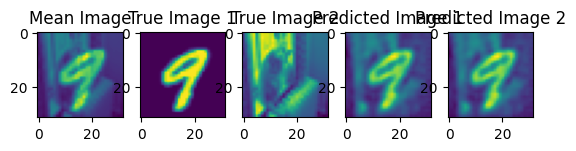

In [26]:
# Test the model
with torch.no_grad():
    for i, data in enumerate(merge_dataloader):
        mean_image, image1, image2 = data
        output, _ = autoencoder(mean_image)
        # Plot the images
        plt.figure(figsize=(20, 10))
        f, axarr = plt.subplots(1, 5)
        axarr[0].imshow(mean_image[0, 0].numpy())
        axarr[0].set_title('Mean Image')
        axarr[1].imshow(image1[0, 0].numpy())
        axarr[1].set_title('True Image 1')
        axarr[2].imshow(image2[0, 0].numpy())
        axarr[2].set_title('True Image 2')
        axarr[3].imshow(output[0, 0].numpy())
        axarr[3].set_title('Predicted Image 1')
        axarr[4].imshow(output[0, 0].numpy())
        axarr[4].set_title('Predicted Image 2')
        plt.show()
        break
